# Source and Sink contributions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import seaborn as sns; sns.set()

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# model results:
year = 2003
results_folder1 = '/data/brogalla/run_storage/Mn-set5-202008/ref-'+str(year)+'/'
results_folder2 = '/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(year)+'/'
results_folder3 = '/data/brogalla/run_storage/Mn-cleanice-202011/clean-ice-'+str(year)+'/'
results_folder4 = '/data/brogalla/run_storage/Mn-upperriv-202011/upper-riv-'+str(year)+'/'
results_folder5 = '/data/brogalla/run_storage/Mn-set6-202011/ref-'+str(year)+'/'
results_folder6 = '/data/brogalla/run_storage/Mn-nosed-202005/nosed-'+str(year)+'/'

# colours:
land_color = "#8b7765"
colors = ['#ccb598', '#367073', '#81a885', '#CC8741', '#cee7fd', '#c7cdd2']

###### Load files:

In [4]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

e1t_base   = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base   = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t        = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)

In [5]:
ref   = nc.Dataset(results_folder2+'ANHA12_EXH006_2003_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [6]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

##### Functions:

In [7]:
def load_results(folder_ref, year):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,isize,jsize))   ; dmn_sed = np.empty((12,isize,jsize)); 
    dmn_atm = np.empty((12,isize,jsize))   ; dmn_ice = np.empty((12,isize,jsize));
    dmn_sedice = np.empty((12,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_'+str(year)+'0101_'+str(year)+'1231_comp_'+str(year)+month+'-'+str(year)+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]
        dmn_sed[i,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]
        dmn_sedice[i,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]
        dmn_atm[i,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]
        dmn_ice[i,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

In [8]:
def plot_experiment(ax, variable, month=0, vmin=0, vmax=7, cmap=cmocean.cm.dense, southern=False):
    
    if southern: 
        proj1 = Basemap(projection='stere',lat_0 = 72.5, lon_0 = -95, resolution='i', width=1.8e6, height=1.1e6, ax=ax)
        proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    else:
        proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -95, resolution='i', width=3.5e6, height=2.98e6, ax=ax)
        proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    x, y = proj1(lons, lats)
    
    c1 = proj1.contourf(x, y, variable[month,:,:], 20, cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    
    return c1

##### Figures

In [9]:
dmn_riv1, dmn_sed1, dmn_sedice1, dmn_atm1, dmn_ice1, dmn_red1, dmn_oxi1 = load_results(results_folder1, 2003)
dmn_riv2, dmn_sed2, dmn_sedice2, dmn_atm2, dmn_ice2, dmn_red2, dmn_oxi2 = load_results(results_folder2, 2003)
dmn_riv3, dmn_sed3, dmn_sedice3, dmn_atm3, dmn_ice3, dmn_red3, dmn_oxi3 = load_results(results_folder3, 2003)
dmn_riv4, dmn_sed4, dmn_sedice4, dmn_atm4, dmn_ice4, dmn_red4, dmn_oxi4 = load_results(results_folder4, 2003)
dmn_riv5, dmn_sed5, dmn_sedice5, dmn_atm5, dmn_ice5, dmn_red5, dmn_oxi5 = load_results(results_folder5, 2003)
dmn_riv6, dmn_sed6, dmn_sedice6, dmn_atm6, dmn_ice6, dmn_red6, dmn_oxi6 = load_results(results_folder6, 2003)

<IPython.core.display.Javascript object>


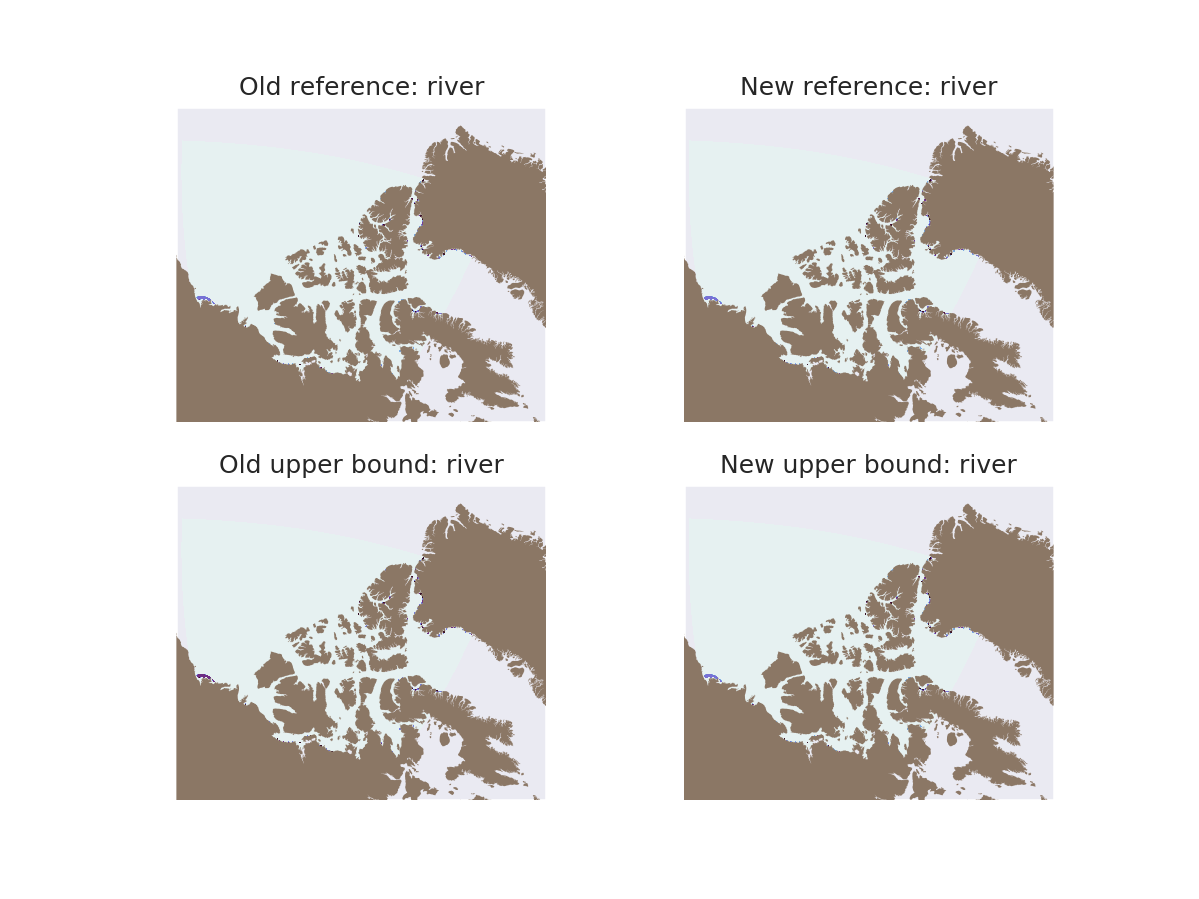

Text(0.5, 1.0, 'New upper bound: river')

In [10]:
month=6; 
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_riv2, month=month, vmin=0, vmax=5e-13)
plot_experiment(ax[0,1], dmn_riv5, month=month, vmin=0, vmax=5e-13)
plot_experiment(ax[1,0], dmn_riv1, month=month, vmin=0, vmax=5e-13)
plot_experiment(ax[1,1], dmn_riv4, month=month, vmin=0, vmax=5e-13)

ax[0,0].set_title('Old reference: river')
ax[0,1].set_title('New reference: river')
ax[1,0].set_title('Old upper bound: river')
ax[1,1].set_title('New upper bound: river')

<IPython.core.display.Javascript object>


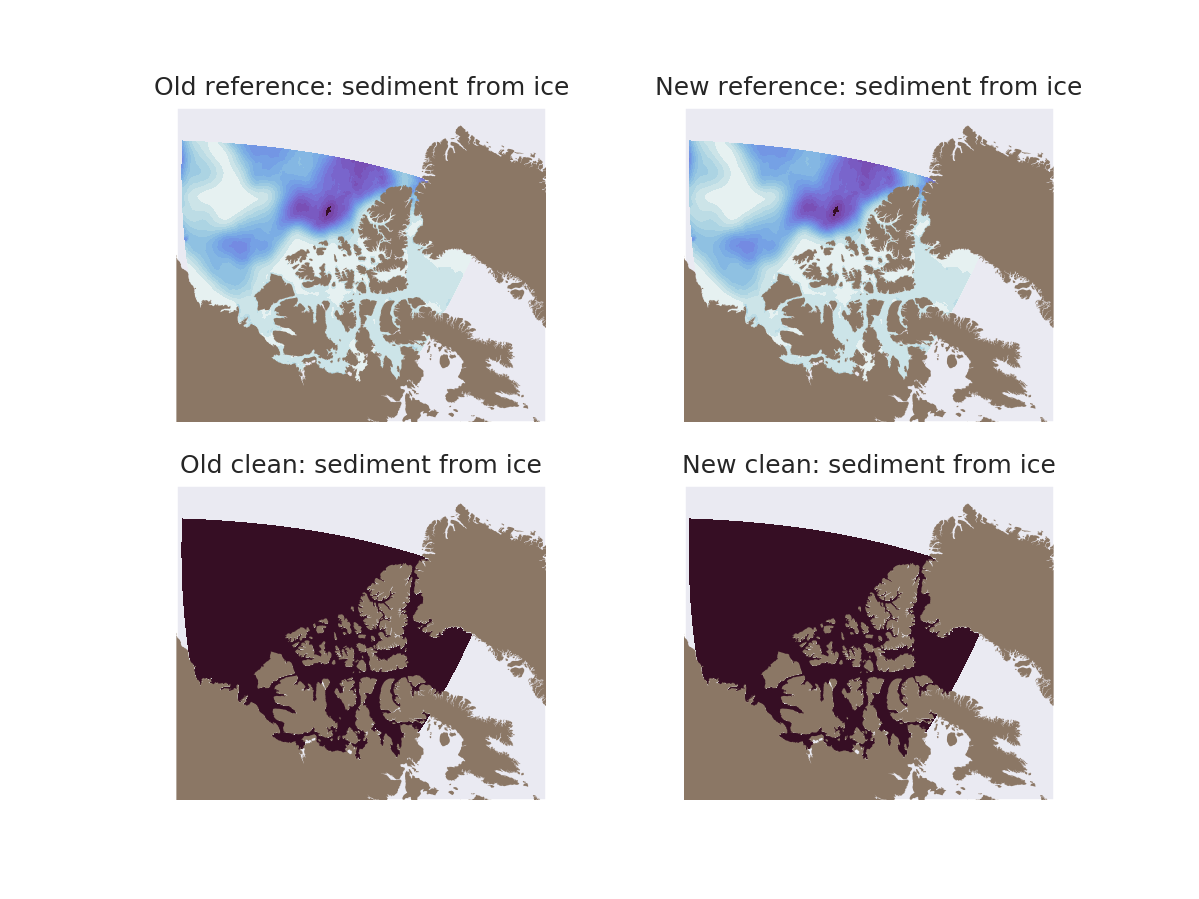

Text(0.5, 1.0, 'New clean: sediment from ice')

In [11]:
month=6; 
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_sedice2, month=month, vmin=0, vmax=1e-13)
plot_experiment(ax[0,1], dmn_sedice5, month=month, vmin=0, vmax=1e-13)
plot_experiment(ax[1,0], dmn_sedice3, month=month, vmin=0, vmax=1e-13)
plot_experiment(ax[1,1], dmn_sedice6, month=month, vmin=0, vmax=1e-13)

ax[0,0].set_title('Old reference: sediment from ice')
ax[0,1].set_title('New reference: sediment from ice')
ax[1,0].set_title('Old clean: sediment from ice')
ax[1,1].set_title('New clean: sediment from ice')

<IPython.core.display.Javascript object>


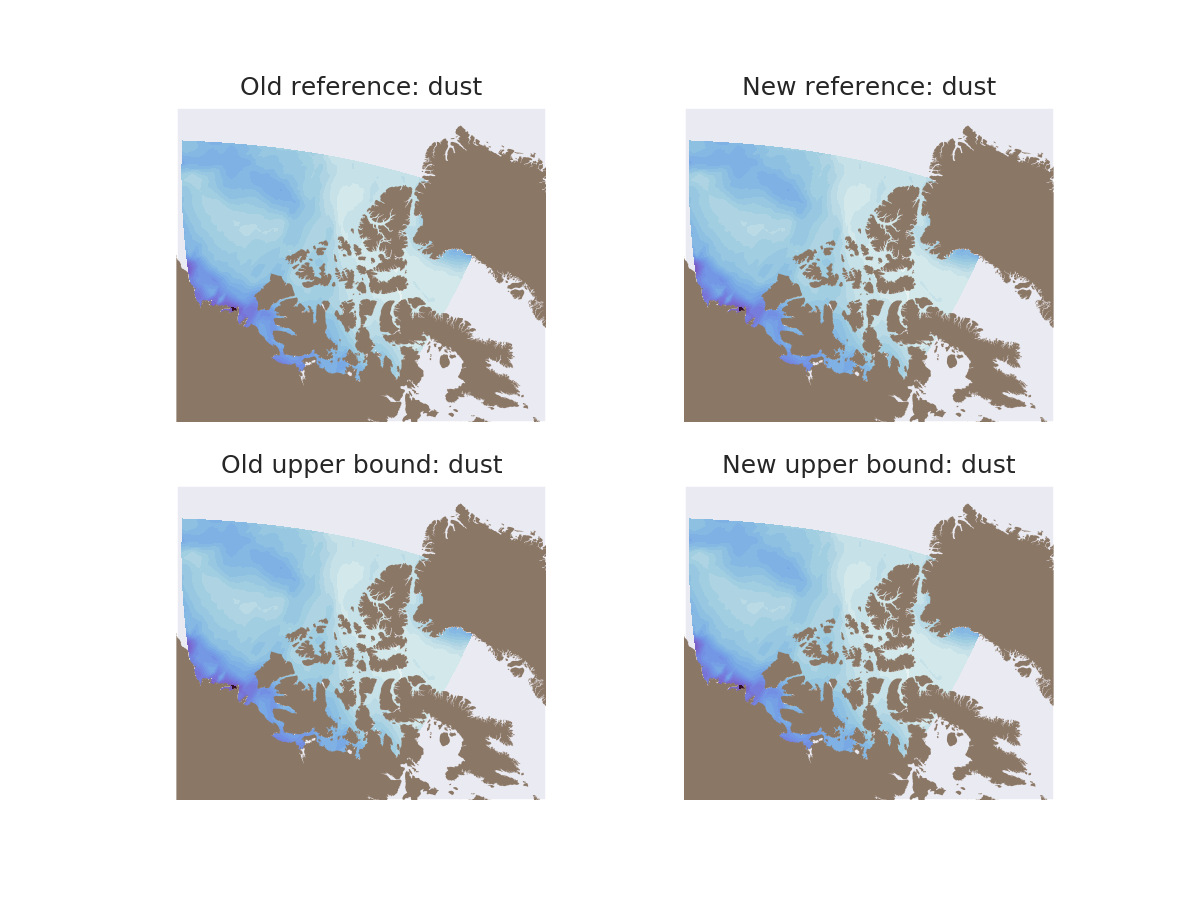

Text(0.5, 1.0, 'New upper bound: dust')

In [12]:
month=6; 
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_atm2, month=month, vmin=0, vmax=1e-19)
plot_experiment(ax[0,1], dmn_atm5, month=month, vmin=0, vmax=1e-17)
plot_experiment(ax[1,0], dmn_atm1, month=month, vmin=0, vmax=1e-19)
plot_experiment(ax[1,1], dmn_atm4, month=month, vmin=0, vmax=1e-17)

ax[0,0].set_title('Old reference: dust')
ax[0,1].set_title('New reference: dust')
ax[1,0].set_title('Old upper bound: dust')
ax[1,1].set_title('New upper bound: dust')

<IPython.core.display.Javascript object>


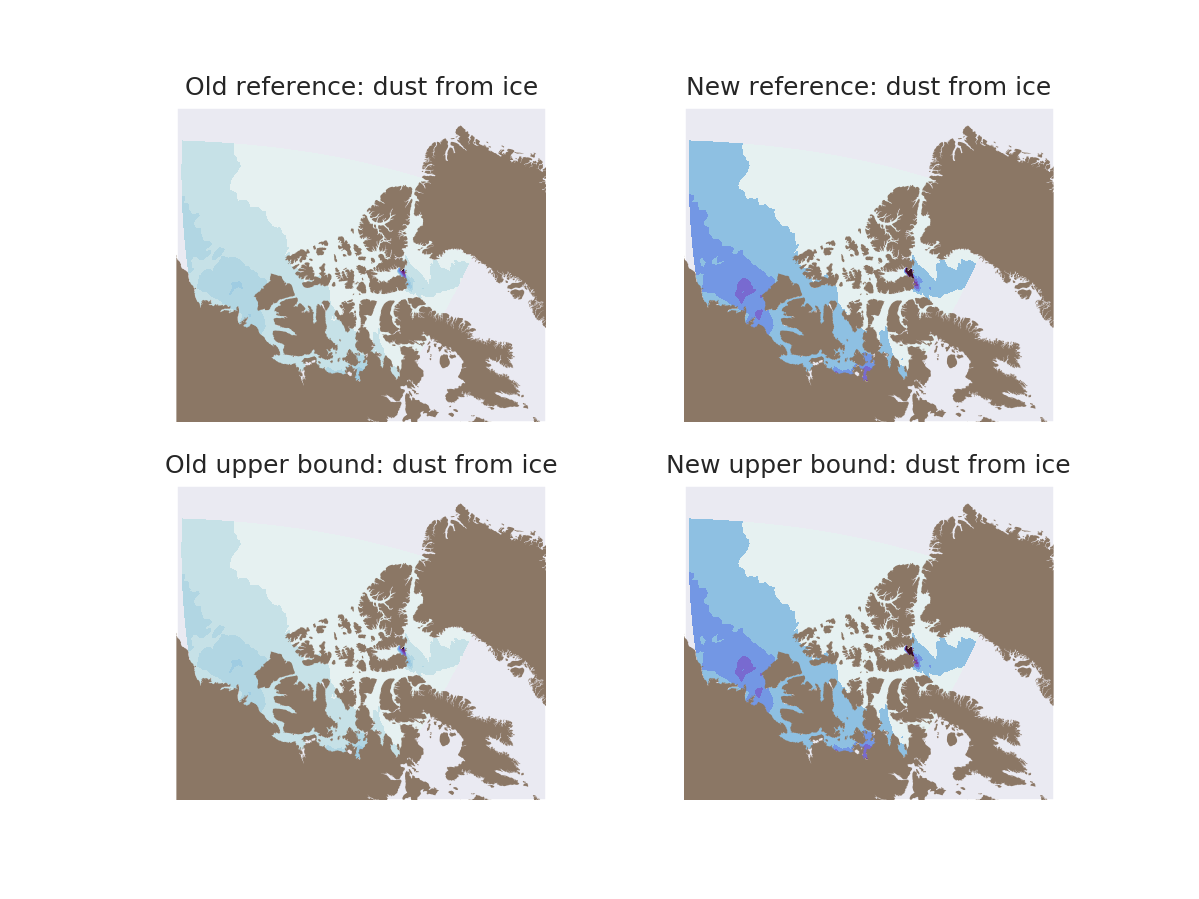

Text(0.5, 1.0, 'New upper bound: dust from ice')

In [13]:
month=6;
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_ice2, month=month, vmin=0, vmax=1e-16)
plot_experiment(ax[0,1], dmn_ice5, month=month, vmin=0, vmax=1e-16)
plot_experiment(ax[1,0], dmn_ice1, month=month, vmin=0, vmax=1e-16)
plot_experiment(ax[1,1], dmn_ice4, month=month, vmin=0, vmax=1e-16)

ax[0,0].set_title('Old reference: dust from ice')
ax[0,1].set_title('New reference: dust from ice')
ax[1,0].set_title('Old upper bound: dust from ice')
ax[1,1].set_title('New upper bound: dust from ice')

<IPython.core.display.Javascript object>


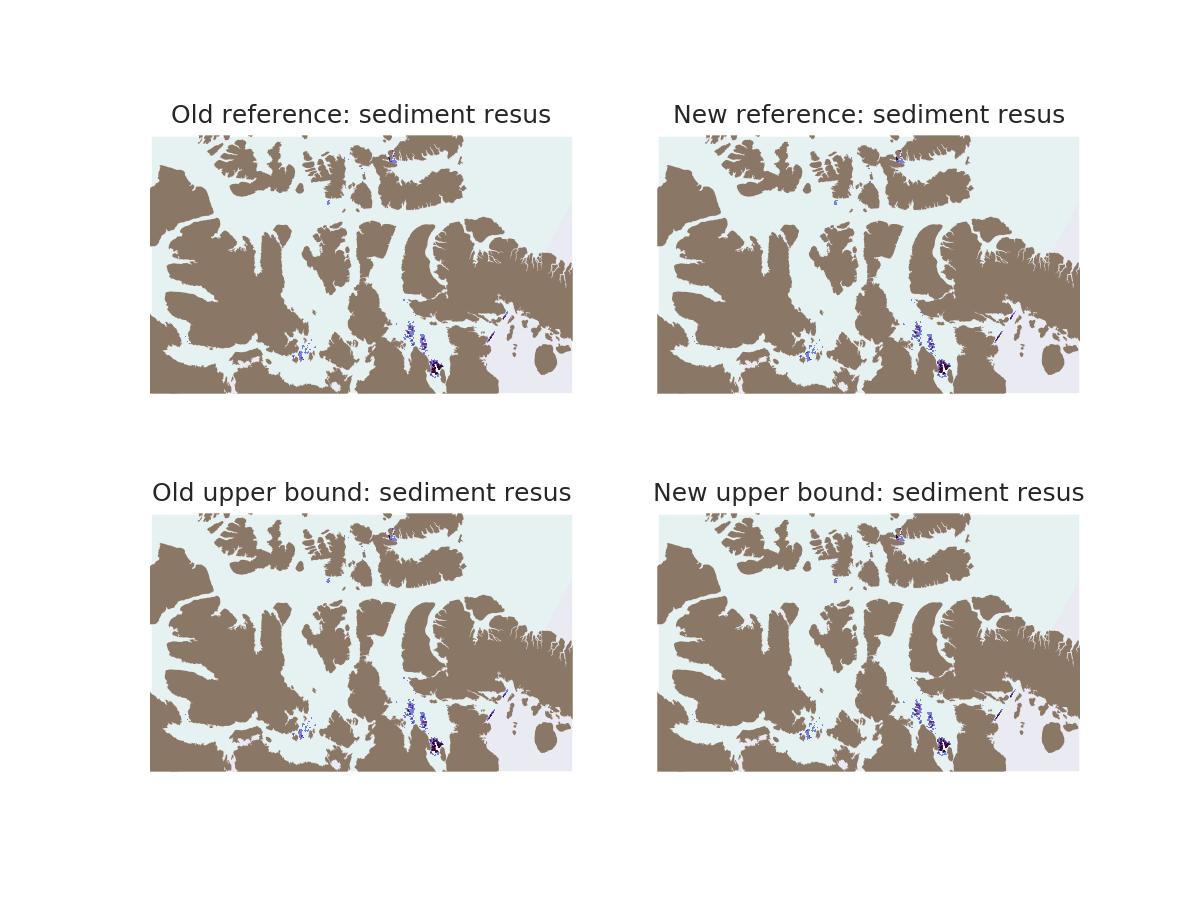

Text(0.5, 1.0, 'New upper bound: sediment resus')

In [14]:
month=6;
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_sed2, month=month, vmin=0, vmax=5e-14, southern=True)
plot_experiment(ax[0,1], dmn_sed5, month=month, vmin=0, vmax=5e-14, southern=True)
plot_experiment(ax[1,0], dmn_sed1, month=month, vmin=0, vmax=5e-14, southern=True)
plot_experiment(ax[1,1], dmn_sed4, month=month, vmin=0, vmax=5e-14, southern=True)

ax[0,0].set_title('Old reference: sediment resus')
ax[0,1].set_title('New reference: sediment resus')
ax[1,0].set_title('Old upper bound: sediment resus')
ax[1,1].set_title('New upper bound: sediment resus')

<IPython.core.display.Javascript object>


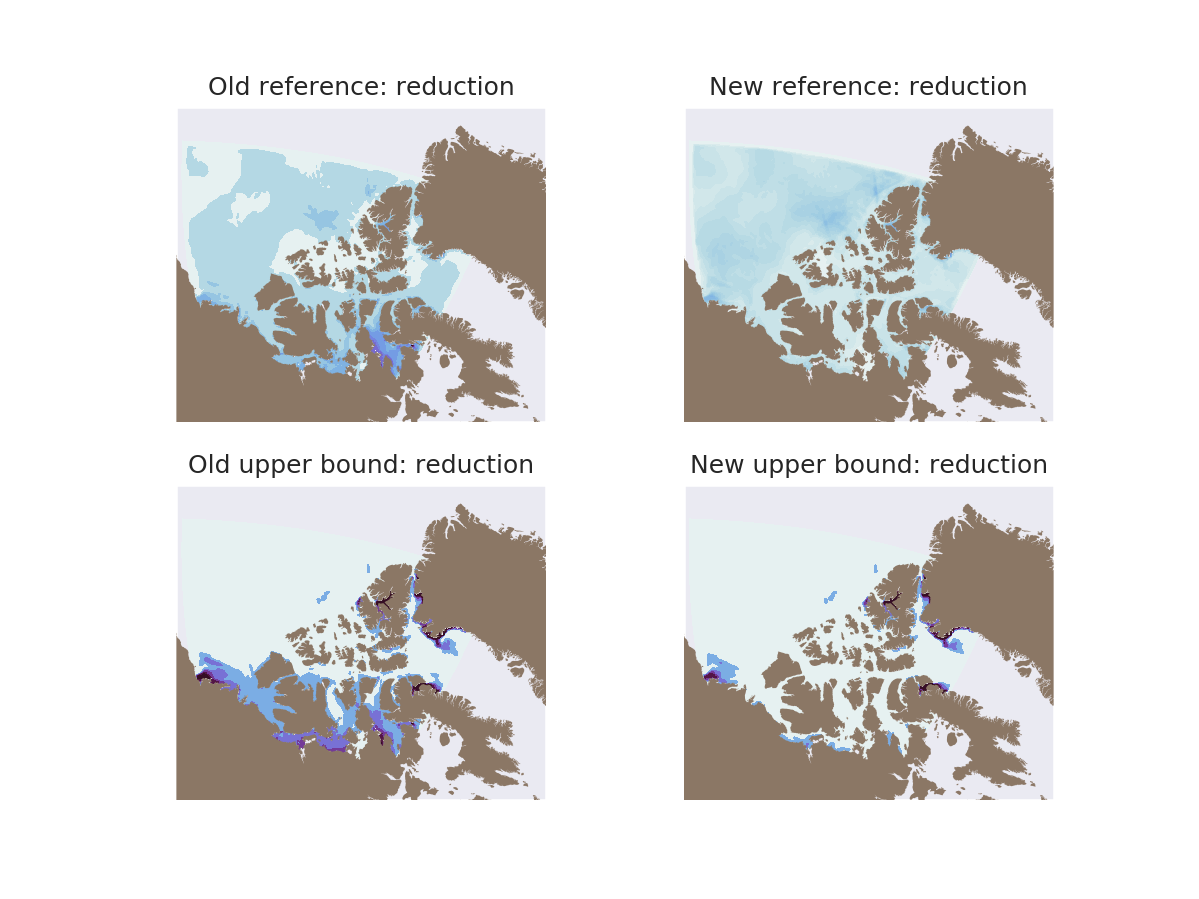

Text(0.5, 1.0, 'New upper bound: reduction')

In [15]:
month=6; layer=0;
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_red2[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[0,1], dmn_red5[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[1,0], dmn_red1[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[1,1], dmn_red4[:,layer,:,:], month=month, vmin=0, vmax=5e-14)

ax[0,0].set_title('Old reference: reduction')
ax[0,1].set_title('New reference: reduction')
ax[1,0].set_title('Old upper bound: reduction')
ax[1,1].set_title('New upper bound: reduction')

<IPython.core.display.Javascript object>


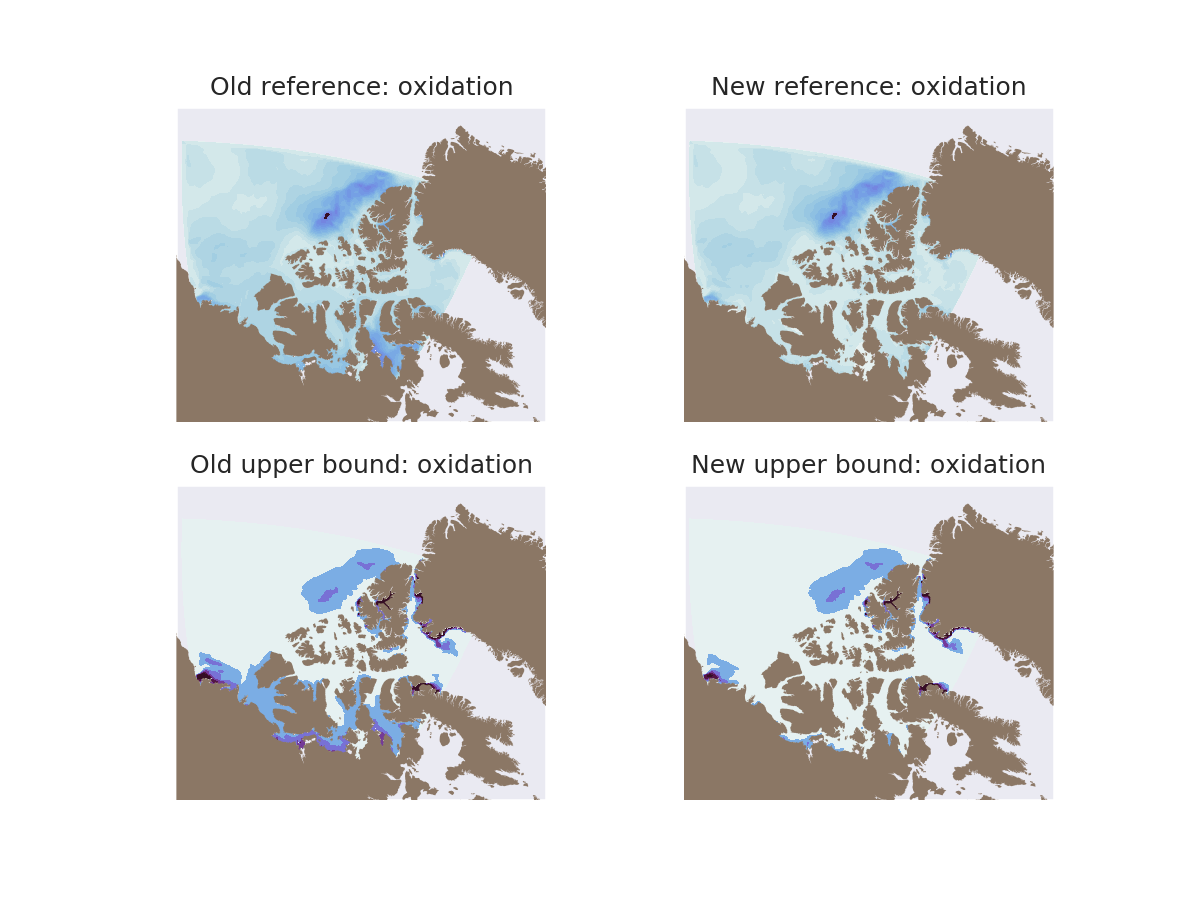

Text(0.5, 1.0, 'New upper bound: oxidation')

In [16]:
month=6; layer=0;
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_oxi2[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[0,1], dmn_oxi5[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[1,0], dmn_oxi1[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[1,1], dmn_oxi4[:,layer,:,:], month=month, vmin=0, vmax=5e-14)

ax[0,0].set_title('Old reference: oxidation')
ax[0,1].set_title('New reference: oxidation')
ax[1,0].set_title('Old upper bound: oxidation')
ax[1,1].set_title('New upper bound: oxidation')

<IPython.core.display.Javascript object>


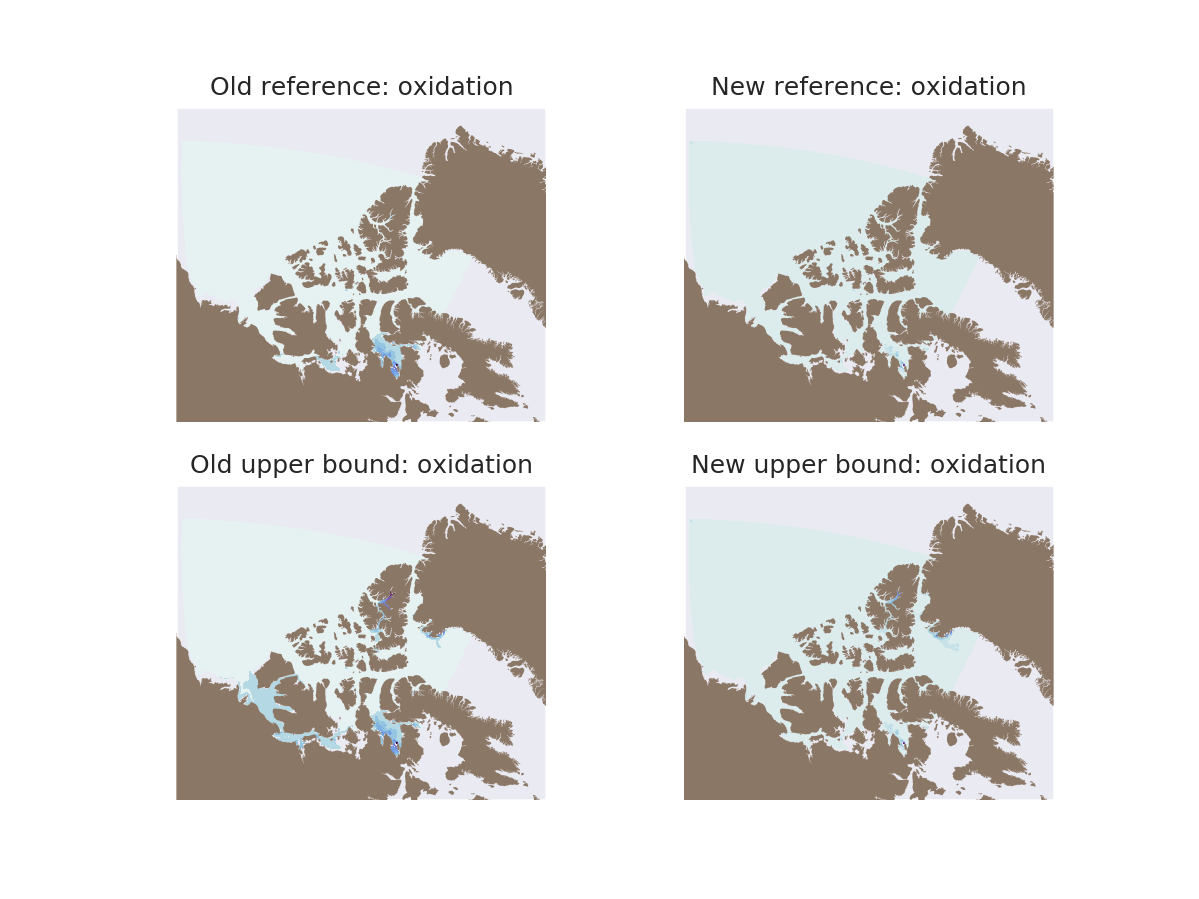

Text(0.5, 1.0, 'New upper bound: oxidation')

In [17]:
month=6; layer=15;
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_oxi2[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[0,1], dmn_oxi5[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[1,0], dmn_oxi1[:,layer,:,:], month=month, vmin=0, vmax=5e-14)
plot_experiment(ax[1,1], dmn_oxi4[:,layer,:,:], month=month, vmin=0, vmax=5e-14)

ax[0,0].set_title('Old reference: oxidation')
ax[0,1].set_title('New reference: oxidation')
ax[1,0].set_title('Old upper bound: oxidation')
ax[1,1].set_title('New upper bound: oxidation')

<IPython.core.display.Javascript object>


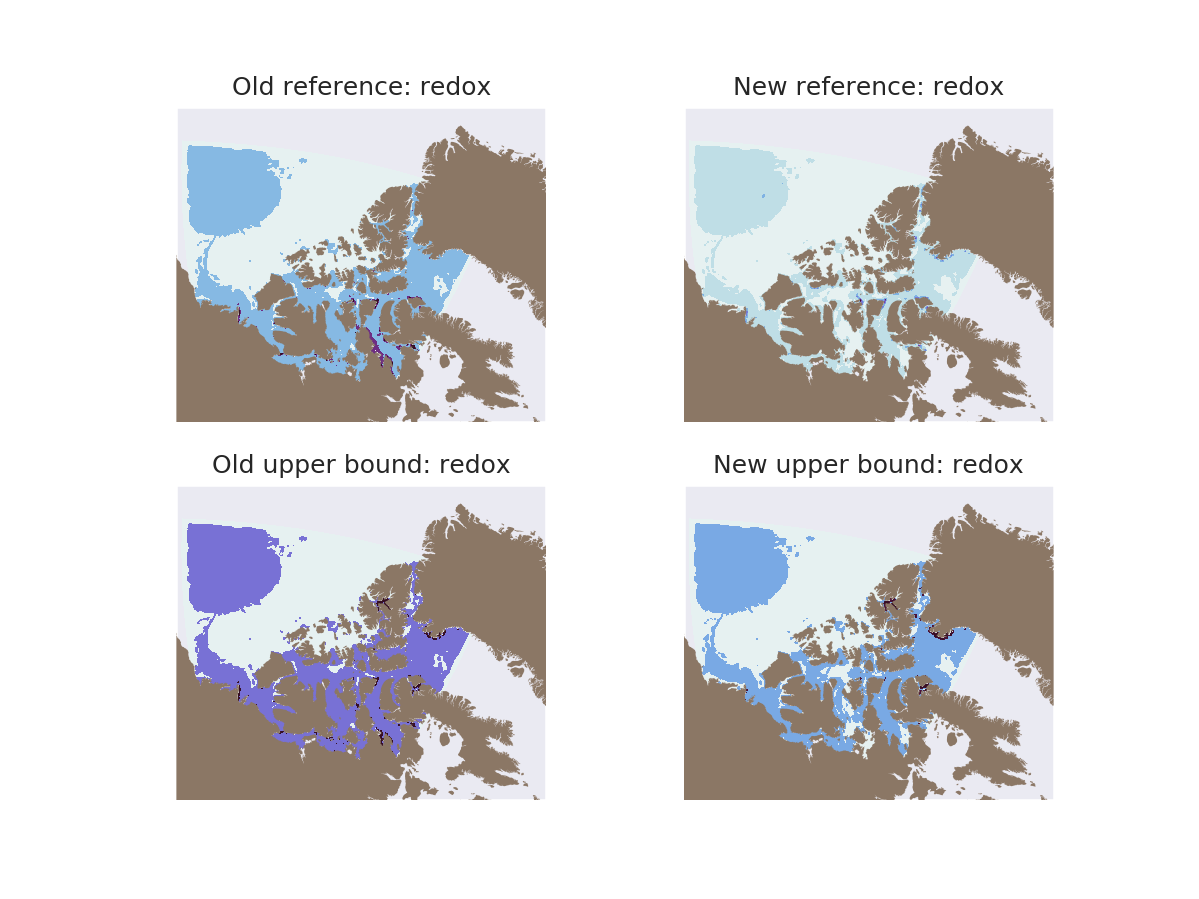

Text(0.5, 1.0, 'New upper bound: redox')

In [18]:
month=6; layer=0;
#---------------------------------------
fig, ax = plt.subplots(2,2, figsize=(8,6))

plot_experiment(ax[0,0], dmn_red2[:,layer,:,:]-dmn_oxi2[:,layer,:,:], month=month, vmin=0, vmax=8e-15)
plot_experiment(ax[0,1], dmn_red5[:,layer,:,:]-dmn_oxi5[:,layer,:,:], month=month, vmin=0, vmax=8e-15)
plot_experiment(ax[1,0], dmn_red1[:,layer,:,:]-dmn_oxi1[:,layer,:,:], month=month, vmin=0, vmax=8e-15)
plot_experiment(ax[1,1], dmn_red4[:,layer,:,:]-dmn_oxi4[:,layer,:,:], month=month, vmin=0, vmax=8e-15)

ax[0,0].set_title('Old reference: redox')
ax[0,1].set_title('New reference: redox')
ax[1,0].set_title('Old upper bound: redox')
ax[1,1].set_title('New upper bound: redox')